In [1]:
%%capture
pip install 'opendp[polars]'

# Explore opendp==0.14
https://docs.opendp.org/en/stable/getting-started/quickstart.html

In [2]:
import opendp.prelude as dp
import polars as pl

dp.enable_features("contrib")

In [3]:
PATH = "penguin.csv"

In [4]:
lf = pl.scan_csv(PATH, ignore_errors=True)
lf

In [5]:
lf.collect().head(2)

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""


# LINEAR REGRESSION

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
dp.enable_features("floating-point", "contrib", "honest-but-curious")

In [8]:
lin_reg = dp.sklearn.linear_model.LinearRegression(
    dp.max_divergence(),
    x_bounds=[(13.0, 23.0)],
    y_bounds=(30.0, 65.0),
    scale=1,
)

In [9]:
df = lf.drop_nulls(["bill_depth_mm", "bill_length_mm"]).collect()
X = df["bill_depth_mm"].to_numpy().reshape(-1, 1) 
y = df["bill_length_mm"].to_numpy()

In [10]:
lin_reg = lin_reg.fit(X=X, y=y)

In [11]:
lin_reg.score(X,y)

0.04900089383827633

In [12]:
lin_reg.intercept_, lin_reg.coef_

(np.float64(57.61111111111112), array([-0.77777778]))

In [13]:
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = lin_reg.predict(x_line)

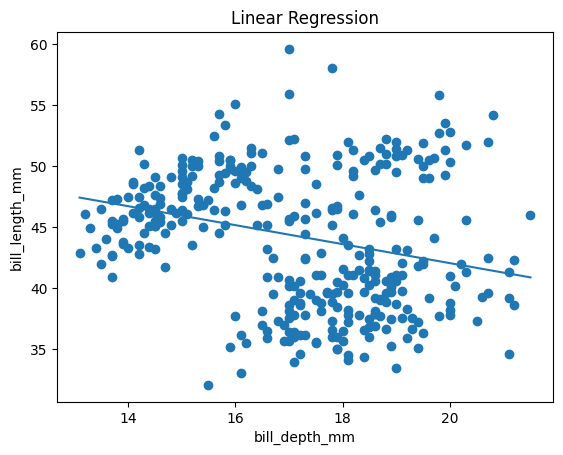

In [14]:
plt.title("Linear Regression")
plt.scatter(X, y)
plt.plot(x_line, y_pred)
plt.xlabel("bill_depth_mm")
plt.ylabel("bill_length_mm")
plt.show()

# SYNTHETIC DATASET

In [15]:
%%capture
!pip install 'opendp[mbi]'

In [16]:
context = dp.Context.compositor(
    data=lf,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(rho=0.19, delta=1e-7),
)

In [17]:
table_aim = (
    context.query(rho=0.1, delta=0.0)
    .select(
        "sex", "species", "island", 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'
    ).contingency_table(
        keys={
            "sex": ["MALE", "FEMALE"],
            "species": ['Adelie', 'Chinstrap', 'Gentoo'],
            "island": ['Dream', 'Torgersen', 'Biscoe']
        },
        cuts={
            "bill_length_mm": [30, 42, 54, 65], 
            'bill_depth_mm': [13, 18, 23], 
            'flipper_length_mm': [150, 200, 250]
        },
        algorithm=dp.mbi.AIM(),
    )
    .release()
)

In [18]:
table_aim.synthesize(rows=100)

sex,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm
str,str,str,f64,f64,f64
null,null,"""Torgersen""",63.428073,12.011735,242.371527
null,"""Adelie""","""Torgersen""",36.607526,12.361657,174.280956
"""FEMALE""","""Adelie""","""Biscoe""",35.742824,23.050219,233.103468
"""FEMALE""","""Adelie""","""Biscoe""",45.293628,23.271865,149.052485
null,"""Chinstrap""","""Biscoe""",56.383911,12.161659,244.991601
…,…,…,…,…,…
"""FEMALE""","""Adelie""","""Torgersen""",33.485823,23.773267,158.132571
"""FEMALE""","""Adelie""","""Biscoe""",64.586968,23.129106,232.721324
null,"""Adelie""","""Biscoe""",55.260847,14.330886,214.90185
